<a href="https://colab.research.google.com/github/isabela-rossetti/classificacao_pyspark/blob/main/PySpark_Classificacao_Heart_Failure_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Preparando o ambiente para utilizar o PySpark**

### **Instalando o Java**

O Apache Spark depende de outros sistemas, portanto, antes do Spark é preciso instalar as dependências. Primeiro, deve-se instalar o java

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

### **Instalando o Apache Spark**

Em seguida, é preciso fazer o download do Spark, e, também, do hadoop, pois o Apache Spark roda sob o HDFS em sua máquina (no caso, na máquina virtual do Google Colab)

In [ ]:
# Fazendo download
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz

# Descompactando os arquivos
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

### **Configurando o ambiente**

Agora é necessário dizer para o sistema onde encontrar o Java e o Spark

In [ ]:
# Importando a biblioteca os
import os

# Definindo a variável de ambiente do Java
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Definindo a variável de ambiente do Spark
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

A seguir, instalar a biblioteca findspark que vai permitir importar pacotes necessários para o funcionamento do pyspark



In [ ]:
# instalando a findspark
!pip install -q findspark

In [ ]:
#importando a findspark
import findspark

# iniciando o findspark
findspark.init()

## **Iniciando o PySpark**

Agora é preciso abrir ums sessão Spark para poder trabalhar com este FrameWork.

In [ ]:
# importando as bibliotecas necessárias
from pyspark import *
from pyspark.sql import *
from pyspark.sql import SparkSession


In [ ]:
# iniciando o spark context
sc = SparkSession.builder.master('local[*]').getOrCreate()

# Verificando se a sessão foi criada
sc

## **Ingestão dos dados para o Apache Spark**

### **Configurando API Kaggle**

In [ ]:
!pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Para criar a API Kaggle, acessar a conta pessoal, ir nas configurações, procurar pelo botão "Create New API Token". Um arquivo no formato JSON chamado "kaggle" será baixado.


In [ ]:
# Selecionar o arquivo kaggle.json baixado no passo anterior
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
import kaggle

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
api = KaggleApi()
api.authenticate()

In [ ]:
# Para baixar o dataset, copiar a URL da página que contém os dados e manter somente o que vem após o "datasets/"
# https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data
api.dataset_download_file('andrewmvd/heart-failure-clinical-data',
                          file_name = 'heart_failure_clinical_records_dataset.csv')

True

In [ ]:
 # Carregando o conjunto de dados
df = (sc.read
      .format('csv')
      .option('inferSchema',True)
      .option('delimiter',',')
      .option('header',True)
      .option('encoding','UTF-8')
      .load('/content/heart_failure_clinical_records_dataset.csv')
)

# Olhando o dataset
df.show()

+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
| age|anaemia|creatinine_phosphokinase|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|
+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|75.0|      0|                     582|       0|               20|                  1| 265000.0|             1.9|         130|  1|      0|   4|          1|
|55.0|      0|                    7861|       0|               38|                  0|263358.03|             1.1|         136|  1|      0|   6|          1|
|65.0|      0|                     146|       0|               20|                  0| 162000.0|             1.3|         129|  1|      1|   7|          1|
|50.0|      1|                     111|       0|               2

In [ ]:
# Verificando o Schema
df.printSchema()

root
 |-- age: double (nullable = true)
 |-- anaemia: integer (nullable = true)
 |-- creatinine_phosphokinase: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- ejection_fraction: integer (nullable = true)
 |-- high_blood_pressure: integer (nullable = true)
 |-- platelets: double (nullable = true)
 |-- serum_creatinine: double (nullable = true)
 |-- serum_sodium: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- smoking: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- DEATH_EVENT: integer (nullable = true)



## **EDA - Análise Exploratória de Dados**


In [ ]:
# Importando os métodos com funções para transformações de variáveis
from pyspark.sql.functions import *

In [ ]:
df.select('age').summary().show()
#df.select('anaemia').summary().show()
df.select('creatinine_phosphokinase').summary().show()
#df.select('diabetes').summary().show()
df.select('ejection_fraction').summary().show()
#df.select('high_blood_pressure').summary().show()
df.select('platelets').summary().show()
df.select('serum_creatinine').summary().show()
df.select('serum_sodium').summary().show()
#df.select('sex').summary().show()
#df.select('smoking').summary().show()
df.select('time').summary().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|               299|
|   mean| 60.83389297658862|
| stddev|11.894809074044469|
|    min|              40.0|
|    25%|              51.0|
|    50%|              60.0|
|    75%|              70.0|
|    max|              95.0|
+-------+------------------+

+-------+------------------------+
|summary|creatinine_phosphokinase|
+-------+------------------------+
|  count|                     299|
|   mean|       581.8394648829432|
| stddev|       970.2878807124358|
|    min|                      23|
|    25%|                     115|
|    50%|                     250|
|    75%|                     582|
|    max|                    7861|
+-------+------------------------+

+-------+------------------+
|summary| ejection_fraction|
+-------+------------------+
|  count|               299|
|   mean| 38.08361204013378|
| stddev|11.834840741039168|
|    min|                14|
|    25%|                30

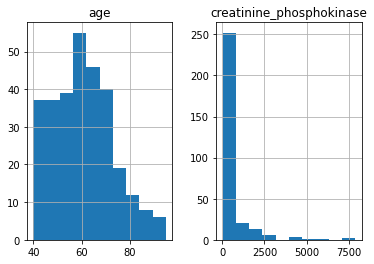

In [ ]:
df.select('age', 'creatinine_phosphokinase').toPandas().hist();

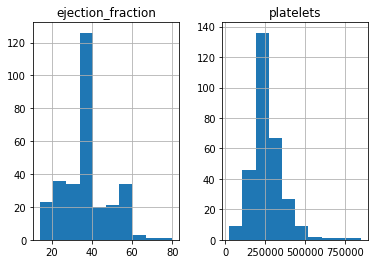

In [ ]:
df.select('ejection_fraction', 'platelets').toPandas().hist();

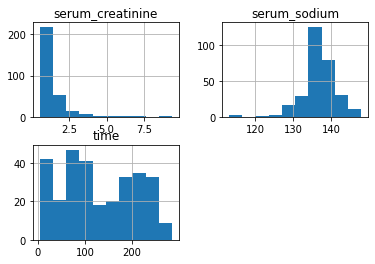

In [ ]:
df.select('serum_creatinine', 'serum_sodium', 'time').toPandas().hist();

In [ ]:
# Alterando o tipo da variável 'DEATH_EVENT'
df2 = df.withColumn("DEATH_EVENT", 
                 df["DEATH_EVENT"].cast('double'))
df2.printSchema()

root
 |-- age: double (nullable = true)
 |-- anaemia: integer (nullable = true)
 |-- creatinine_phosphokinase: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- ejection_fraction: integer (nullable = true)
 |-- high_blood_pressure: integer (nullable = true)
 |-- platelets: double (nullable = true)
 |-- serum_creatinine: double (nullable = true)
 |-- serum_sodium: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- smoking: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
df.crosstab('smoking', 'DEATH_EVENT').show()

+-------------------+---+---+
|smoking_DEATH_EVENT|  0|  1|
+-------------------+---+---+
|                  1| 66| 30|
|                  0|137| 66|
+-------------------+---+---+



In [ ]:
df.crosstab('sex', 'DEATH_EVENT').show()

+---------------+---+---+
|sex_DEATH_EVENT|  0|  1|
+---------------+---+---+
|              1|132| 62|
|              0| 71| 34|
+---------------+---+---+



In [ ]:
df.crosstab('anaemia', 'DEATH_EVENT').show()

+-------------------+---+---+
|anaemia_DEATH_EVENT|  0|  1|
+-------------------+---+---+
|                  1| 83| 46|
|                  0|120| 50|
+-------------------+---+---+



In [ ]:
df.crosstab('diabetes', 'DEATH_EVENT').show()

+--------------------+---+---+
|diabetes_DEATH_EVENT|  0|  1|
+--------------------+---+---+
|                   1| 85| 40|
|                   0|118| 56|
+--------------------+---+---+



In [ ]:
#df.crosstab('time', 'DEATH_EVENT').show()
df.groupby('DEATH_EVENT').avg().show()

+-----------+-----------------+------------------+-----------------------------+------------------+----------------------+------------------------+-----------------+---------------------+-----------------+------------------+------------------+-----------------+----------------+
|DEATH_EVENT|         avg(age)|      avg(anaemia)|avg(creatinine_phosphokinase)|     avg(diabetes)|avg(ejection_fraction)|avg(high_blood_pressure)|   avg(platelets)|avg(serum_creatinine)|avg(serum_sodium)|          avg(sex)|      avg(smoking)|        avg(time)|avg(DEATH_EVENT)|
+-----------+-----------------+------------------+-----------------------------+------------------+----------------------+------------------------+-----------------+---------------------+-----------------+------------------+------------------+-----------------+----------------+
|          1|      65.21528125|0.4791666666666667|            670.1979166666666|0.4166666666666667|              33.46875|                 0.40625|256381.044791666

In [ ]:
df.createOrReplaceTempView("tabela")
sc.sql("SELECT avg(time) as media_tempo_internacao, count(DEATH_EVENT) from tabela").show()

+----------------------+------------------+
|media_tempo_internacao|count(DEATH_EVENT)|
+----------------------+------------------+
|     130.2608695652174|               299|
+----------------------+------------------+



## **Categorizando variáveis (não executar)**

In [ ]:
from pyspark.sql.functions import *

In [ ]:
df.select('platelets').summary().show()

+-------+------------------+
|summary|         platelets|
+-------+------------------+
|  count|               299|
|   mean|263358.02926421416|
| stddev|  97804.2368685983|
|    min|           25100.0|
|    25%|          212000.0|
|    50%|          262000.0|
|    75%|          304000.0|
|    max|          850000.0|
+-------+------------------+



In [ ]:
# Classificando o nível das plaquetas (fonte: https://www.cuf.pt/mais-saude/plaquetas-baixas-o-que-pode-significar#:~:text=As%20plaquetas%20s%C3%A3o%20c%C3%A9lulas%20do,cancro%20e%20algumas%20doen%C3%A7as%20cr%C3%B3nicas.)
df2 = df.withColumn(
    colName = 'platelets_faixa', 
    col = (
        when(df['platelets']<=150000.0,' baixa').
        when(((df['platelets']>150000.0) & 
            (df['platelets']<=400000.0)),'normal').
       otherwise('alta')
           ) 
    ).show

In [ ]:
df.select('creatinine_phosphokinase').summary().show()

+-------+------------------------+
|summary|creatinine_phosphokinase|
+-------+------------------------+
|  count|                     299|
|   mean|       581.8394648829432|
| stddev|       970.2878807124358|
|    min|                      23|
|    25%|                     115|
|    50%|                     250|
|    75%|                     582|
|    max|                    7861|
+-------+------------------------+



In [ ]:
# Classificando o nível das plaquetas (fonte: https://www.cuf.pt/mais-saude/plaquetas-baixas-o-que-pode-significar#:~:text=As%20plaquetas%20s%C3%A3o%20c%C3%A9lulas%20do,cancro%20e%20algumas%20doen%C3%A7as%20cr%C3%B3nicas.)
df3 = df.withColumn(
    colName = 'creatinine_phosphokinase_faixa', 
    col = (
        when(df['creatinine_phosphokinase']<=29.00),' baixa').
        when(((df['creatinine_phosphokinase']>29.00) & 
            (df['creatinine_phosphokinase']<=200.00)),'normal').
       otherwise('alta')
    ).show()


#Os valores de referência da CPK são entre 30.00 U/L e 200.00 U/L para homens e 
#                                    entre 29.00 U/L e 168.00 U/L para mulheres. 
  

# **Teste 1 - Todas as variáveis, nenhuma transformação**

## **Pré-Processamento para Machine Learning**

In [ ]:
# Importando Bibliotecas e métodos necessários
import pandas as pd
from pyspark.sql.functions import *
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

In [ ]:
COLUMNS = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction','high_blood_pressure','platelets','serum_creatinine','serum_sodium',
           'sex','smoking']

In [ ]:
# criando uma coluna com todas as preditoras
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Definindo as preditoras
def_preditoras = VectorAssembler(inputCols=COLUMNS, outputCol='preditoras')

# criando uma coluna com todas as preditoras em novo dataset
df_pred = def_preditoras.transform(df)

# Pegando somente os atributos que serao utilizados na modelagem
df_ml = df_pred.select('DEATH_EVENT', 'preditoras')

# Espiando dataset final
df_ml.show()

+-----------+--------------------+
|DEATH_EVENT|          preditoras|
+-----------+--------------------+
|          1|[75.0,0.0,582.0,0...|
|          1|[55.0,0.0,7861.0,...|
|          1|[65.0,0.0,146.0,0...|
|          1|[50.0,1.0,111.0,0...|
|          1|[65.0,1.0,160.0,1...|
|          1|[90.0,1.0,47.0,0....|
|          1|[75.0,1.0,246.0,0...|
|          1|[60.0,1.0,315.0,1...|
|          1|(11,[0,2,4,6,7,8]...|
|          1|[80.0,1.0,123.0,0...|
|          1|[75.0,1.0,81.0,0....|
|          1|[62.0,0.0,231.0,0...|
|          1|[45.0,1.0,981.0,0...|
|          1|[50.0,1.0,168.0,0...|
|          0|[49.0,1.0,80.0,0....|
|          1|[82.0,1.0,379.0,0...|
|          1|[87.0,1.0,149.0,0...|
|          1|[45.0,0.0,582.0,0...|
|          1|[70.0,1.0,125.0,0...|
|          1|[48.0,1.0,582.0,1...|
+-----------+--------------------+
only showing top 20 rows



## **Dividindo o dataset entre treino e teste**

In [ ]:
# Separando os dados entre treino e teste
df_treino, df_teste = df_ml.randomSplit([.75,.25], seed=23112022)

## **Regressão Logística**

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
# Definindo
rl= LogisticRegression(
    featuresCol='preditoras', 
    labelCol='DEATH_EVENT', 
    predictionCol='DEATH_EVENT_PRED')

In [ ]:
# Treinando
modelo_rl = rl.fit(df_treino)

In [ ]:
# Ajustando aos dados de teste
modelo_rl_pred = modelo_rl.transform(df_teste)

In [ ]:
# Selecionando a coluna do valor_total preditas e observadas
predita_observada_rl = modelo_rl_pred.select('DEATH_EVENT_PRED','DEATH_EVENT')
predita_observada_rl.show()

+----------------+-----------+
|DEATH_EVENT_PRED|DEATH_EVENT|
+----------------+-----------+
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
+----------------+-----------+
only showing top 20 rows



In [ ]:
# Matriz de confusão
predita_observada_rl\
  .crosstab('DEATH_EVENT', 'DEATH_EVENT_PRED')\
  .orderBy('DEATH_EVENT_DEATH_EVENT_PRED')\
  .show()

+----------------------------+---+---+
|DEATH_EVENT_DEATH_EVENT_PRED|0.0|1.0|
+----------------------------+---+---+
|                           0| 50|  4|
|                           1| 19| 11|
+----------------------------+---+---+



In [ ]:
# Alterando o tipo da variável
predita_observada_rl = predita_observada_rl.withColumn("DEATH_EVENT", 
                 predita_observada_rl["DEATH_EVENT"].cast('double'))
predita_observada_rl.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_rl = BinaryClassificationMetrics(predita_observada_rl.rdd)
metricas_modelo_rl = MulticlassMetrics(predita_observada_rl.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_rl.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_rl.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_rl.areaUnderROC,'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_rl.confusionMatrix())

Acurácia: 0.7262
F1 Score: 0.6973
AUC: 0.6463 

matriz de confusão
DenseMatrix([[50.,  4.],
             [19., 11.]])


## **Árvore de Decisão**

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

In [ ]:
# definindo a árvore
dt= DecisionTreeClassifier(
    featuresCol='preditoras', 
    labelCol='DEATH_EVENT', 
    predictionCol='DEATH_EVENT_PRED',
    maxDepth=5)

In [ ]:
# Treinando a árvore
modelo_dt = dt.fit(df_treino)

In [ ]:
# Ajustando a árvore aos dados de teste
modelo_dt_pred = modelo_dt.transform(df_teste)

In [ ]:
# Selecionando a coluna valor_total preditas e observadas
predita_observada_dt = modelo_dt_pred.select('DEATH_EVENT_PRED','DEATH_EVENT')
predita_observada_dt.show()

+----------------+-----------+
|DEATH_EVENT_PRED|DEATH_EVENT|
+----------------+-----------+
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             1.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             1.0|          0|
|             0.0|          0|
|             0.0|          0|
+----------------+-----------+
only showing top 20 rows



In [ ]:
# Matriz de confusão
predita_observada_dt\
  .crosstab('DEATH_EVENT', 'DEATH_EVENT_PRED')\
  .orderBy('DEATH_EVENT_DEATH_EVENT_PRED')\
  .show()

+----------------------------+---+---+
|DEATH_EVENT_DEATH_EVENT_PRED|0.0|1.0|
+----------------------------+---+---+
|                           0| 46|  8|
|                           1| 15| 15|
+----------------------------+---+---+



In [ ]:
# Alterando o tipo da variável
predita_observada_dt = predita_observada_dt.withColumn("DEATH_EVENT", 
                 predita_observada_dt["DEATH_EVENT"].cast('double'))
predita_observada_dt.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_dt = BinaryClassificationMetrics(predita_observada_dt.rdd)
metricas_modelo_dt = MulticlassMetrics(predita_observada_dt.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_dt.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_dt.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_dt.areaUnderROC,'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_dt.confusionMatrix())

Acurácia: 0.7262
F1 Score: 0.7164
AUC: 0.6759 

matriz de confusão
DenseMatrix([[46.,  8.],
             [15., 15.]])


## **Random Forest**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
# definindo a floresta
rf= RandomForestClassifier(
    featuresCol='preditoras', 
    labelCol='DEATH_EVENT', 
    predictionCol='DEATH_EVENT_PRED',
    maxDepth=5, 
    numTrees=100)

In [ ]:
# Treinando a floresta
modelo_rf = rf.fit(df_treino)

In [ ]:
# Ajustando a floresta aos dados de teste
modelo_rf_pred = modelo_rf.transform(df_teste)

In [ ]:
# Selecionando as colunas valor_total preditas e observadas
predita_observada_rf = modelo_rf_pred.select('DEATH_EVENT_PRED','DEATH_EVENT')
predita_observada_rf.show()

+----------------+-----------+
|DEATH_EVENT_PRED|DEATH_EVENT|
+----------------+-----------+
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             1.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
+----------------+-----------+
only showing top 20 rows



In [ ]:
# Matriz de confusão
predita_observada_rf\
  .crosstab('DEATH_EVENT', 'DEATH_EVENT_PRED')\
  .orderBy('DEATH_EVENT_DEATH_EVENT_PRED')\
  .show()

+----------------------------+---+---+
|DEATH_EVENT_DEATH_EVENT_PRED|0.0|1.0|
+----------------------------+---+---+
|                           0| 49|  5|
|                           1| 20| 10|
+----------------------------+---+---+



In [ ]:
# Alterando o tipo da variável
predita_observada_rf = predita_observada_rf.withColumn("DEATH_EVENT", 
                 predita_observada_rf["DEATH_EVENT"].cast('double'))
predita_observada_rf.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_rf = BinaryClassificationMetrics(predita_observada_rf.rdd)
metricas_modelo_rf = MulticlassMetrics(predita_observada_rf.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_rf.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_rf.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_rf.areaUnderROC,'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_rf.confusionMatrix())

Acurácia: 0.7024
F1 Score: 0.6709
AUC: 0.6204 

matriz de confusão
DenseMatrix([[49.,  5.],
             [20., 10.]])


## **Tunando o melhor modelo**

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 

### **Configurações gerais**

In [ ]:
# definindo a árvore
arvore = DecisionTreeClassifier(
    featuresCol='preditoras', 
    labelCol='DEATH_EVENT', 
    predictionCol='DEATH_EVENT_PRED',
    maxDepth=5)

In [ ]:
pipeline = Pipeline(stages=[arvore])

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(arvore.maxDepth, [3, 4, 5, 6, 7,8]) \
    .build()

In [ ]:
paramGrid

[{Param(parent='DecisionTreeClassifier_201c05676234', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3},
 {Param(parent='DecisionTreeClassifier_201c05676234', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4},
 {Param(parent='DecisionTreeClassifier_201c05676234', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5},
 {Param(parent='DecisionTreeClassifier_201c05676234', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 6},
 {Param(parent='DecisionTreeClassifier_201c05676234', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 7},
 {Param(parent='Deci

In [ ]:
avaliador = MulticlassClassificationEvaluator(
    predictionCol="DEATH_EVENT_PRED", 
    labelCol='DEATH_EVENT', 
    metricName='f1'
)

### **Utilizando TrainValidationSplit**

In [ ]:
# Definindo a tunagem através um hold-out com 1-fold
tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=avaliador,
                           trainRatio=0.8)

In [ ]:
# Rodando hold-out e escolhendo o melhor conjunto de parâmetros
modelo_dt_tvs = tvs.fit(df_treino)

In [ ]:
# Criando um dataframe com os modelos e o valor de f1 de cada modelo
modelos = pd.DataFrame(data=modelo_dt_tvs.getEstimatorParamMaps())
metricas = pd.DataFrame(data=modelo_dt_tvs.validationMetrics, columns=['f1'])
df_f1 = pd.merge(left = modelos,right = metricas, left_index=True, right_index=True)
df_f1.sort_values(by=['f1'], inplace=True, ascending=False)
df_f1.head(24)

,DecisionTreeClassifier_201c05676234__maxDepth,f1
0,3,0.714762
2,5,0.681463
1,4,0.670879
4,7,0.633366
5,8,0.633366
3,6,0.626996


In [ ]:
# Aplicando o melhor modelo ao conjunto de teste
# Pegando os valores observados e preditos da variável target
predita_observada_tvs = modelo_dt_tvs.\
                        transform(df_teste).\
                        select('DEATH_EVENT_PRED','DEATH_EVENT')

In [ ]:
# Matriz de confusão
predita_observada_tvs\
  .crosstab('DEATH_EVENT', 'DEATH_EVENT_PRED')\
  .orderBy('DEATH_EVENT_DEATH_EVENT_PRED')\
  .show()

+----------------------------+---+---+
|DEATH_EVENT_DEATH_EVENT_PRED|0.0|1.0|
+----------------------------+---+---+
|                           0| 46|  8|
|                           1| 14| 16|
+----------------------------+---+---+



In [ ]:
# Alterando o tipo da variável
predita_observada_tvs = predita_observada_tvs.withColumn("DEATH_EVENT", 
                 predita_observada_tvs["DEATH_EVENT"].cast('double'))
predita_observada_tvs.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_dt_tvs = BinaryClassificationMetrics(predita_observada_tvs.rdd)
metricas_modelo_dt_tvs = MulticlassMetrics(predita_observada_tvs.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_dt_tvs.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_dt_tvs.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_dt_tvs.areaUnderROC,'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_dt_tvs.confusionMatrix())

Acurácia: 0.7381
F1 Score: 0.7304
AUC: 0.6926 

matriz de confusão
DenseMatrix([[46.,  8.],
             [14., 16.]])


### **Utilizando o CrossValidator**

In [ ]:
# Definindo a validação cruzada com 3-fold
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=avaliador,
                          numFolds=3)

In [ ]:
# Rodando a validação cruzada e escolhendo o melhor conjunto de parâmetros
modelo_dt_cv = crossval.fit(df_treino)

In [ ]:
# Criando um dataframe com os modelos e o valor de f1 de cada modelo
modelos = pd.DataFrame(data=modelo_dt_cv.getEstimatorParamMaps())
metricas = pd.DataFrame(data=modelo_dt_cv.avgMetrics, columns=['f1'])
df_f1 = pd.merge(left = modelos,right = metricas, left_index=True, right_index=True)
df_f1.sort_values(by=['f1'], inplace=True, ascending=False)
df_f1.head(24)

,DecisionTreeClassifier_201c05676234__maxDepth,f1
1,4,0.741267
3,6,0.733130
2,5,0.728859
0,3,0.725332
5,8,0.720449
4,7,0.706398


In [ ]:
# Aplicando o melhor modelo ao conjunto de teste
# Pegando os valores observados e preditos da variável target
predita_observada_cv = modelo_dt_cv\
                        .transform(df_teste)\
                        .select('DEATH_EVENT_PRED','DEATH_EVENT')

In [ ]:
# Alterando o tipo da variável
predita_observada_cv = predita_observada_cv.withColumn("DEATH_EVENT", 
                                  predita_observada_cv["DEATH_EVENT"]
                                  .cast('double'))
predita_observada_cv.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_dt_cv = BinaryClassificationMetrics(predita_observada_cv.rdd)
metricas_modelo_dt_cv = MulticlassMetrics(predita_observada_cv.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_dt_cv.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_dt_cv.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_dt_cv.areaUnderROC,'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_dt_cv.confusionMatrix())

Acurácia: 0.7381
F1 Score: 0.7230
AUC: 0.6778 

matriz de confusão
DenseMatrix([[48.,  6.],
             [16., 14.]])


# **Teste 2 - Variáveis selecionadas. Nenhuma transformação**

## **Pré-Processamento para Machine Learning**

In [ ]:
from pyspark.ml.stat import Correlation

In [ ]:
for i in df.columns:
    if not(isinstance(df.select(i).take(1)[0][0], str)):

        print("Correlação de DEATH_EVENT com", i,
               df.stat.corr('DEATH_EVENT',i))

Correlação de DEATH_EVENT com age 0.25372854308800347
Correlação de DEATH_EVENT com anaemia 0.06627009846028793
Correlação de DEATH_EVENT com creatinine_phosphokinase 0.06272816025237478
Correlação de DEATH_EVENT com diabetes -0.0019428833442033963
Correlação de DEATH_EVENT com ejection_fraction -0.2686033123940612
Correlação de DEATH_EVENT com high_blood_pressure 0.07935105769128528
Correlação de DEATH_EVENT com platelets -0.04913886798037408
Correlação de DEATH_EVENT com serum_creatinine 0.29427756098414926
Correlação de DEATH_EVENT com serum_sodium -0.1952035964164019
Correlação de DEATH_EVENT com sex -0.00431637631970314
Correlação de DEATH_EVENT com smoking -0.012623152709359337
Correlação de DEATH_EVENT com time -0.5269637792775774
Correlação de DEATH_EVENT com DEATH_EVENT 1.0


In [ ]:
#selecionando variáveis com correlação -0.1 < death_event > 0,1 
COLUMNS = ['age','ejection_fraction','serum_creatinine','serum_sodium','time']

In [ ]:
# criando uma coluna com todas as preditoras
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Definindo as preditoras
def_preditoras = VectorAssembler(inputCols=COLUMNS, outputCol='preditoras')

# Criando uma coluna com todas as preditoras em novo dataset
df_pred = def_preditoras.transform(df)

# Transformando os dados
#standardScaler = StandardScaler(inputCol='preditoras', outputCol='preditoras_scaled')
#scaled_df = standardScaler.fit(df_pred).transform(df_pred)
#scaled_df.select('preditoras', 'preditoras_scaled').show(10, truncate=False)

In [ ]:
# Pegando somente os atributos que serao utilizados na modelagem
df_ml = df_pred.select('DEATH_EVENT', 'preditoras')

# Espiando dataset final
df_ml.show()

+-----------+--------------------+
|DEATH_EVENT|          preditoras|
+-----------+--------------------+
|          1|[75.0,20.0,1.9,13...|
|          1|[55.0,38.0,1.1,13...|
|          1|[65.0,20.0,1.3,12...|
|          1|[50.0,20.0,1.9,13...|
|          1|[65.0,20.0,2.7,11...|
|          1|[90.0,40.0,2.1,13...|
|          1|[75.0,15.0,1.2,13...|
|          1|[60.0,60.0,1.1,13...|
|          1|[65.0,65.0,1.5,13...|
|          1|[80.0,35.0,9.4,13...|
|          1|[75.0,38.0,4.0,13...|
|          1|[62.0,25.0,0.9,14...|
|          1|[45.0,30.0,1.1,13...|
|          1|[50.0,38.0,1.1,13...|
|          0|[49.0,30.0,1.0,13...|
|          1|[82.0,50.0,1.3,13...|
|          1|[87.0,38.0,0.9,14...|
|          1|[45.0,14.0,0.8,12...|
|          1|[70.0,25.0,1.0,14...|
|          1|[48.0,55.0,1.9,12...|
+-----------+--------------------+
only showing top 20 rows



## **Dividindo o dataset entre treino e teste**

In [ ]:
# Separando os dados entre treino e teste
df_treino, df_teste = df_ml.randomSplit([.75,.25], seed=23112022)

## **Regressão Logística**

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
# Definindo
rl= LogisticRegression(
    featuresCol='preditoras', 
    labelCol='DEATH_EVENT', 
    predictionCol='DEATH_EVENT_PRED')

In [ ]:
# Treinando
modelo_rl = rl.fit(df_treino)

In [ ]:
# Ajustando aos dados de teste
modelo_rl_pred = modelo_rl.transform(df_teste)

In [ ]:
# Selecionando a coluna do valor_total preditas e observadas
predita_observada_rl = modelo_rl_pred.select('DEATH_EVENT_PRED','DEATH_EVENT')
predita_observada_rl.show()

+----------------+-----------+
|DEATH_EVENT_PRED|DEATH_EVENT|
+----------------+-----------+
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             1.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
+----------------+-----------+
only showing top 20 rows



In [ ]:
# Matriz de confusão
predita_observada_rl\
  .crosstab('DEATH_EVENT', 'DEATH_EVENT_PRED')\
  .orderBy('DEATH_EVENT_DEATH_EVENT_PRED')\
  .show()

+----------------------------+---+---+
|DEATH_EVENT_DEATH_EVENT_PRED|0.0|1.0|
+----------------------------+---+---+
|                           0| 51|  3|
|                           1| 16| 14|
+----------------------------+---+---+



In [ ]:
# Alterando o tipo da variável
predita_observada_rl = predita_observada_rl.withColumn("DEATH_EVENT", 
                 predita_observada_rl["DEATH_EVENT"].cast('double'))
predita_observada_rl.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_rl = BinaryClassificationMetrics(predita_observada_rl.rdd)
metricas_modelo_rl = MulticlassMetrics(predita_observada_rl.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_rl.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_rl.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_rl.areaUnderROC,'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_rl.confusionMatrix())

Acurácia: 0.7738
F1 Score: 0.7547
AUC: 0.7056 

matriz de confusão
DenseMatrix([[51.,  3.],
             [16., 14.]])


## **Árvore de Decisão**

In [ ]:
# definindo a árvore
dt= DecisionTreeClassifier(
    featuresCol='preditoras', 
    labelCol='DEATH_EVENT', 
    predictionCol='DEATH_EVENT_PRED',
    maxDepth=5)

In [ ]:
# Treinando a árvore
modelo_dt = dt.fit(df_treino)

In [ ]:
# Ajustando a árvore aos dados de teste
modelo_dt_pred = modelo_dt.transform(df_teste)

In [ ]:
# Selecionando a coluna valor_total preditas e observadas
predita_observada_dt = modelo_dt_pred.select('DEATH_EVENT_PRED','DEATH_EVENT')
predita_observada_dt.show()

+----------------+-----------+
|DEATH_EVENT_PRED|DEATH_EVENT|
+----------------+-----------+
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             1.0|          0|
|             1.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
+----------------+-----------+
only showing top 20 rows



In [ ]:
# Matriz de confusão
predita_observada_dt\
  .crosstab('DEATH_EVENT', 'DEATH_EVENT_PRED')\
  .orderBy('DEATH_EVENT_DEATH_EVENT_PRED')\
  .show()

+----------------------------+---+---+
|DEATH_EVENT_DEATH_EVENT_PRED|0.0|1.0|
+----------------------------+---+---+
|                           0| 50|  4|
|                           1| 16| 14|
+----------------------------+---+---+



In [ ]:
# Alterando o tipo da variável
predita_observada_dt = predita_observada_dt.withColumn("DEATH_EVENT", 
                 predita_observada_dt["DEATH_EVENT"].cast('double'))
predita_observada_dt.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_dt = BinaryClassificationMetrics(predita_observada_dt.rdd)
metricas_modelo_dt = MulticlassMetrics(predita_observada_dt.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_dt.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_dt.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_dt.areaUnderROC,'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_dt.confusionMatrix())

Acurácia: 0.7619
F1 Score: 0.7440
AUC: 0.6963 

matriz de confusão
DenseMatrix([[50.,  4.],
             [16., 14.]])


## **Random Forest**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
# definindo a floresta
rf= RandomForestClassifier(
    featuresCol='preditoras', 
    labelCol='DEATH_EVENT', 
    predictionCol='DEATH_EVENT_PRED',
    maxDepth=5, 
    numTrees=100)

In [ ]:
# Treinando a floresta
modelo_rf = rf.fit(df_treino)

In [ ]:
# Ajustando a floresta aos dados de teste
modelo_rf_pred = modelo_rf.transform(df_teste)

In [ ]:
# Selecionando as colunas valor_total preditas e observadas
predita_observada_rf = modelo_rf_pred.select('DEATH_EVENT_PRED','DEATH_EVENT')
predita_observada_rf.show()

+----------------+-----------+
|DEATH_EVENT_PRED|DEATH_EVENT|
+----------------+-----------+
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             1.0|          0|
|             1.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
+----------------+-----------+
only showing top 20 rows



In [ ]:
# Matriz de confusão
predita_observada_rf\
  .crosstab('DEATH_EVENT', 'DEATH_EVENT_PRED')\
  .orderBy('DEATH_EVENT_DEATH_EVENT_PRED')\
  .show()

+----------------------------+---+---+
|DEATH_EVENT_DEATH_EVENT_PRED|0.0|1.0|
+----------------------------+---+---+
|                           0| 50|  4|
|                           1| 15| 15|
+----------------------------+---+---+



In [ ]:
# Alterando o tipo da variável
predita_observada_rf = predita_observada_rf.withColumn("DEATH_EVENT", 
                 predita_observada_rf["DEATH_EVENT"].cast('double'))
predita_observada_rf.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_rf = BinaryClassificationMetrics(predita_observada_rf.rdd)
metricas_modelo_rf = MulticlassMetrics(predita_observada_rf.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_rf.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_rf.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_rf.areaUnderROC,'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_rf.confusionMatrix())

Acurácia: 0.7738
F1 Score: 0.7589
AUC: 0.7130 

matriz de confusão
DenseMatrix([[50.,  4.],
             [15., 15.]])


## **Tunando o melhor modelo**

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 

### **Configurações gerais**

In [ ]:
# definindo a floresta
floresta = RandomForestClassifier(
    featuresCol='preditoras', 
    labelCol='DEATH_EVENT', 
    predictionCol='DEATH_EVENT_PRED'
    )

In [ ]:
pipeline = Pipeline(stages=[floresta])

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(floresta.maxDepth, [3, 4, 5, 6, 7,8]) \
    .addGrid(floresta.numTrees, [10, 50, 100, 1000]) \
    .build()

In [ ]:
paramGrid

In [ ]:
avaliador = MulticlassClassificationEvaluator(
    predictionCol="DEATH_EVENT_PRED", 
    labelCol='DEATH_EVENT', 
    metricName='f1'
)

### **Utilizando TrainValidationSplit**

In [ ]:
# Definindo a tunagem através um hold-out com 1-fold
tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=avaliador,
                           trainRatio=0.8)

In [ ]:
# Rodando hold-out e escolhendo o melhor conjunto de parâmetros
modelo_rf_tvs = tvs.fit(df_treino)

In [ ]:
# Criando um dataframe com os modelos e o valor de f1 de cada modelo
modelos = pd.DataFrame(data=modelo_rf_tvs.getEstimatorParamMaps())
metricas = pd.DataFrame(data=modelo_rf_tvs.validationMetrics, columns=['f1'])
df_f1 = pd.merge(left = modelos,right = metricas, left_index=True, right_index=True)
df_f1.sort_values(by=['f1'], inplace=True, ascending=False)
df_f1.head(24)

,RandomForestClassifier_551876c96534__maxDepth,RandomForestClassifier_551876c96534__numTrees,f1
18,7,100,0.913043
22,8,100,0.913043
14,6,100,0.913043
1,3,50,0.911297
3,3,1000,0.911297
6,4,100,0.911297
23,8,1000,0.890293
15,6,1000,0.890293
10,5,100,0.890293
19,7,1000,0.890293


In [ ]:
# Aplicando o melhor modelo ao conjunto de teste
# Pegando os valores observados e preditos da variável target
predita_observada_tvs = modelo_rf_tvs.\
                        transform(df_teste).\
                        select('DEATH_EVENT_PRED','DEATH_EVENT')

In [ ]:
# Matriz de confusão
predita_observada_tvs\
  .crosstab('DEATH_EVENT', 'DEATH_EVENT_PRED')\
  .orderBy('DEATH_EVENT_DEATH_EVENT_PRED')\
  .show()

+----------------------------+---+---+
|DEATH_EVENT_DEATH_EVENT_PRED|0.0|1.0|
+----------------------------+---+---+
|                           0| 50|  4|
|                           1| 15| 15|
+----------------------------+---+---+



In [ ]:
# Alterando o tipo da variável
predita_observada_tvs = predita_observada_tvs.withColumn("DEATH_EVENT", 
                 predita_observada_tvs["DEATH_EVENT"].cast('double'))
predita_observada_tvs.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_rf_tvs = BinaryClassificationMetrics(predita_observada_tvs.rdd)
metricas_modelo_rf_tvs = MulticlassMetrics(predita_observada_tvs.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_rf_tvs.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_rf_tvs.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_rf_tvs.areaUnderROC,'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_rf_tvs.confusionMatrix())

Acurácia: 0.7738
F1 Score: 0.7589
AUC: 0.7130 

matriz de confusão
DenseMatrix([[50.,  4.],
             [15., 15.]])


### **Utilizando o CrossValidator**

In [ ]:
# Definindo a validação cruzada com 3-fold
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=avaliador,
                          numFolds=3)

In [ ]:
# Rodando a validação cruzada e escolhendo o melhor conjunto de parâmetros
modelo_rf_cv = crossval.fit(df_treino)

In [ ]:
# Criando um dataframe com os modelos e o valor de f1 de cada modelo
modelos = pd.DataFrame(data=modelo_rf_cv.getEstimatorParamMaps())
metricas = pd.DataFrame(data=modelo_rf_cv.avgMetrics, columns=['f1'])
df_f1 = pd.merge(left = modelos,right = metricas, left_index=True, right_index=True)
df_f1.sort_values(by=['f1'], inplace=True, ascending=False)
df_f1.head(24)

,RandomForestClassifier_551876c96534__maxDepth,RandomForestClassifier_551876c96534__numTrees,f1
9,5,50,0.890976
17,7,50,0.886415
13,6,50,0.886415
5,4,50,0.886400
1,3,50,0.885905
21,8,50,0.882245
6,4,100,0.877176
22,8,100,0.877176
11,5,1000,0.877176
7,4,1000,0.876555


In [ ]:
# Aplicando o melhor modelo ao conjunto de teste
# Pegando os valores observados e preditos da variável target
predita_observada_cv = modelo_rf_cv\
                        .transform(df_teste)\
                        .select('DEATH_EVENT_PRED','DEATH_EVENT')

In [ ]:
# Alterando o tipo da variável
predita_observada_cv = predita_observada_cv.withColumn("DEATH_EVENT", 
                                  predita_observada_cv["DEATH_EVENT"]
                                  .cast('double'))
predita_observada_cv.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_rf_cv = BinaryClassificationMetrics(predita_observada_cv.rdd)
metricas_modelo_rf_cv = MulticlassMetrics(predita_observada_cv.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_rf_cv.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_rf_cv.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_rf_cv.areaUnderROC,'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_rf_cv.confusionMatrix())

Acurácia: 0.7738
F1 Score: 0.7589
AUC: 0.7130 

matriz de confusão
DenseMatrix([[50.,  4.],
             [15., 15.]])


# **Teste 3 - Variáveis: serum creatinine e ejection fraction . Nenhuma transformação**

Citation
Davide Chicco, Giuseppe Jurman: Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Medical Informatics and Decision Making 20, 16 (2020).
https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5

## **Pré-Processamento para Machine Learning**

In [ ]:
COLUMNS = ['serum_creatinine', 'ejection_fraction']

In [ ]:
# criando uma coluna com todas as preditoras
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Definindo as preditoras
def_preditoras = VectorAssembler(inputCols=COLUMNS, outputCol='preditoras')

# Criando uma coluna com todas as preditoras em novo dataset
df_pred = def_preditoras.transform(df)

# Transformando os dados
#standardScaler = StandardScaler(inputCol='preditoras', outputCol='preditoras_scaled')
#scaled_df = standardScaler.fit(df_pred).transform(df_pred)
#scaled_df.select('preditoras', 'preditoras_scaled').show(10, truncate=False)

In [ ]:
# Pegando somente os atributos que serao utilizados na modelagem
df_ml = df_pred.select('DEATH_EVENT', 'preditoras')

# Espiando dataset final
df_ml.show()

+-----------+----------+
|DEATH_EVENT|preditoras|
+-----------+----------+
|          1|[1.9,20.0]|
|          1|[1.1,38.0]|
|          1|[1.3,20.0]|
|          1|[1.9,20.0]|
|          1|[2.7,20.0]|
|          1|[2.1,40.0]|
|          1|[1.2,15.0]|
|          1|[1.1,60.0]|
|          1|[1.5,65.0]|
|          1|[9.4,35.0]|
|          1|[4.0,38.0]|
|          1|[0.9,25.0]|
|          1|[1.1,30.0]|
|          1|[1.1,38.0]|
|          0|[1.0,30.0]|
|          1|[1.3,50.0]|
|          1|[0.9,38.0]|
|          1|[0.8,14.0]|
|          1|[1.0,25.0]|
|          1|[1.9,55.0]|
+-----------+----------+
only showing top 20 rows



## **Dividindo o dataset entre treino e teste**

In [ ]:
# Separando os dados entre treino e teste
df_treino, df_teste = df_ml.randomSplit([.75,.25], seed=23112022)

## **Regressão Logística**

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
# Definindo
rl= LogisticRegression(
    featuresCol='preditoras', 
    labelCol='DEATH_EVENT', 
    predictionCol='DEATH_EVENT_PRED')

In [ ]:
# Treinando
modelo_rl = rl.fit(df_treino)

In [ ]:
# Ajustando aos dados de teste
modelo_rl_pred = modelo_rl.transform(df_teste)

In [ ]:
# Selecionando a coluna do valor_total preditas e observadas
predita_observada_rl = modelo_rl_pred.select('DEATH_EVENT_PRED','DEATH_EVENT')
predita_observada_rl.show()

+----------------+-----------+
|DEATH_EVENT_PRED|DEATH_EVENT|
+----------------+-----------+
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
+----------------+-----------+
only showing top 20 rows



In [ ]:
# Matriz de confusão
predita_observada_rl\
  .crosstab('DEATH_EVENT', 'DEATH_EVENT_PRED')\
  .orderBy('DEATH_EVENT_DEATH_EVENT_PRED')\
  .show()

+----------------------------+---+---+
|DEATH_EVENT_DEATH_EVENT_PRED|0.0|1.0|
+----------------------------+---+---+
|                           0| 52|  2|
|                           1| 20| 10|
+----------------------------+---+---+



In [ ]:
# Alterando o tipo da variável
predita_observada_rl = predita_observada_rl.withColumn("DEATH_EVENT", 
                 predita_observada_rl["DEATH_EVENT"].cast('double'))
predita_observada_rl.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_rl = BinaryClassificationMetrics(predita_observada_rl.rdd)
metricas_modelo_rl = MulticlassMetrics(predita_observada_rl.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_rl.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_rl.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_rl.areaUnderROC,'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_rl.confusionMatrix())

Acurácia: 0.7381
F1 Score: 0.7007
AUC: 0.6481 

matriz de confusão
DenseMatrix([[52.,  2.],
             [20., 10.]])


## **Árvore de Decisão**

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

In [ ]:
# definindo a árvore
dt= DecisionTreeClassifier(
    featuresCol='preditoras', 
    labelCol='DEATH_EVENT', 
    predictionCol='DEATH_EVENT_PRED',
    maxDepth=5)

In [ ]:
# Treinando a árvore
modelo_dt = dt.fit(df_treino)

In [ ]:
# Ajustando a árvore aos dados de teste
modelo_dt_pred = modelo_dt.transform(df_teste)

In [ ]:
# Selecionando a coluna valor_total preditas e observadas
predita_observada_dt = modelo_dt_pred.select('DEATH_EVENT_PRED','DEATH_EVENT')
predita_observada_dt.show()

+----------------+-----------+
|DEATH_EVENT_PRED|DEATH_EVENT|
+----------------+-----------+
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             1.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
+----------------+-----------+
only showing top 20 rows



In [ ]:
# Matriz de confusão
predita_observada_dt\
  .crosstab('DEATH_EVENT', 'DEATH_EVENT_PRED')\
  .orderBy('DEATH_EVENT_DEATH_EVENT_PRED')\
  .show()

+----------------------------+---+---+
|DEATH_EVENT_DEATH_EVENT_PRED|0.0|1.0|
+----------------------------+---+---+
|                           0| 51|  3|
|                           1| 19| 11|
+----------------------------+---+---+



In [ ]:
# Alterando o tipo da variável
predita_observada_dt = predita_observada_dt.withColumn("DEATH_EVENT", 
                 predita_observada_dt["DEATH_EVENT"].cast('double'))
predita_observada_dt.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_dt = BinaryClassificationMetrics(predita_observada_dt.rdd)
metricas_modelo_dt = MulticlassMetrics(predita_observada_dt.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_dt.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_dt.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_dt.areaUnderROC,'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_dt.confusionMatrix())

Acurácia: 0.7381
F1 Score: 0.7074
AUC: 0.6556 

matriz de confusão
DenseMatrix([[51.,  3.],
             [19., 11.]])


## **Random Forest**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
# definindo a floresta
rf= RandomForestClassifier(
    featuresCol='preditoras', 
    labelCol='DEATH_EVENT', 
    predictionCol='DEATH_EVENT_PRED',
    maxDepth=5, 
    numTrees=100)

In [ ]:
# Treinando a floresta
modelo_rf = rf.fit(df_treino)

In [ ]:
# Ajustando a floresta aos dados de teste
modelo_rf_pred = modelo_rf.transform(df_teste)

In [ ]:
# Selecionando as colunas valor_total preditas e observadas
predita_observada_rf = modelo_rf_pred.select('DEATH_EVENT_PRED','DEATH_EVENT')
predita_observada_rf.show()

+----------------+-----------+
|DEATH_EVENT_PRED|DEATH_EVENT|
+----------------+-----------+
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             1.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
|             0.0|          0|
+----------------+-----------+
only showing top 20 rows



In [ ]:
# Matriz de confusão
predita_observada_rf\
  .crosstab('DEATH_EVENT', 'DEATH_EVENT_PRED')\
  .orderBy('DEATH_EVENT_DEATH_EVENT_PRED')\
  .show()

+----------------------------+---+---+
|DEATH_EVENT_DEATH_EVENT_PRED|0.0|1.0|
+----------------------------+---+---+
|                           0| 50|  4|
|                           1| 17| 13|
+----------------------------+---+---+



In [ ]:
# Alterando o tipo da variável
predita_observada_rf = predita_observada_rf.withColumn("DEATH_EVENT", 
                 predita_observada_rf["DEATH_EVENT"].cast('double'))
predita_observada_rf.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_rf = BinaryClassificationMetrics(predita_observada_rf.rdd)
metricas_modelo_rf = MulticlassMetrics(predita_observada_rf.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_rf.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_rf.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_rf.areaUnderROC,'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_rf.confusionMatrix())

Acurácia: 0.7500
F1 Score: 0.7289
AUC: 0.6796 

matriz de confusão
DenseMatrix([[50.,  4.],
             [17., 13.]])


## **Tunando o melhor modelo**

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 

### **Configurações gerais**

In [ ]:
# definindo a floresta
floresta = RandomForestClassifier(
    featuresCol='preditoras', 
    labelCol='DEATH_EVENT', 
    predictionCol='DEATH_EVENT_PRED'
    )

In [ ]:
pipeline = Pipeline(stages=[floresta])

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(floresta.maxDepth, [3, 4, 5, 6, 7,8]) \
    .addGrid(floresta.numTrees, [10, 50, 100, 1000]) \
    .build()

In [ ]:
paramGrid

[{Param(parent='RandomForestClassifier_c67edd695dea', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3,
  Param(parent='RandomForestClassifier_c67edd695dea', name='numTrees', doc='Number of trees to train (>= 1).'): 10},
 {Param(parent='RandomForestClassifier_c67edd695dea', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3,
  Param(parent='RandomForestClassifier_c67edd695dea', name='numTrees', doc='Number of trees to train (>= 1).'): 50},
 {Param(parent='RandomForestClassifier_c67edd695dea', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3,
  Param(parent='RandomForestClassifier_c67edd695dea', name='numTrees', doc='Number of trees to train (>= 1).'): 100},
 {Param(parent='RandomForestClassifier_c67edd695dea', name='max

In [ ]:
avaliador = MulticlassClassificationEvaluator(
    predictionCol="DEATH_EVENT_PRED", 
    labelCol='DEATH_EVENT', 
    metricName='f1'
)

### **Utilizando TrainValidationSplit**

In [ ]:
# Definindo a tunagem através um hold-out com 1-fold
tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=avaliador,
                           trainRatio=0.8)

In [ ]:
# Rodando hold-out e escolhendo o melhor conjunto de parâmetros
modelo_rf_tvs = tvs.fit(df_treino)

In [ ]:
import pandas as pd

In [ ]:
# Criando um dataframe com os modelos e o valor de f1 de cada modelo
modelos = pd.DataFrame(data=modelo_rf_tvs.getEstimatorParamMaps())
metricas = pd.DataFrame(data=modelo_rf_tvs.validationMetrics, columns=['f1'])
df_f1 = pd.merge(left = modelos,right = metricas, left_index=True, right_index=True)
df_f1.sort_values(by=['f1'], inplace=True, ascending=False)
df_f1.head(24)

,RandomForestClassifier_c67edd695dea__maxDepth,RandomForestClassifier_c67edd695dea__numTrees,f1
4,4,10,0.710271
0,3,10,0.689032
20,8,10,0.682780
16,7,10,0.682780
8,5,10,0.661983
1,3,50,0.661983
12,6,10,0.661983
7,4,1000,0.646473
14,6,100,0.641190
22,8,100,0.641190


In [ ]:
# Aplicando o melhor modelo ao conjunto de teste
# Pegando os valores observados e preditos da variável target
predita_observada_tvs = modelo_rf_tvs.\
                        transform(df_teste).\
                        select('DEATH_EVENT_PRED','DEATH_EVENT')

In [ ]:
# Matriz de confusão
predita_observada_tvs\
  .crosstab('DEATH_EVENT', 'DEATH_EVENT_PRED')\
  .orderBy('DEATH_EVENT_DEATH_EVENT_PRED')\
  .show()

+----------------------------+---+---+
|DEATH_EVENT_DEATH_EVENT_PRED|0.0|1.0|
+----------------------------+---+---+
|                           0| 49|  5|
|                           1| 16| 14|
+----------------------------+---+---+



In [ ]:
# Alterando o tipo da variável
predita_observada_tvs = predita_observada_tvs.withColumn("DEATH_EVENT", 
                 predita_observada_tvs["DEATH_EVENT"].cast('double'))
predita_observada_tvs.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_rf_tvs = BinaryClassificationMetrics(predita_observada_tvs.rdd)
metricas_modelo_rf_tvs = MulticlassMetrics(predita_observada_tvs.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_rf_tvs.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_rf_tvs.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_rf_tvs.areaUnderROC,'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_rf_tvs.confusionMatrix())

Acurácia: 0.7500
F1 Score: 0.7335
AUC: 0.6870 

matriz de confusão
DenseMatrix([[49.,  5.],
             [16., 14.]])


### **Utilizando o CrossValidator**

In [ ]:
# Definindo a validação cruzada com 3-fold
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=avaliador,
                          numFolds=3)

In [ ]:
# Rodando a validação cruzada e escolhendo o melhor conjunto de parâmetros
modelo_rf_cv = crossval.fit(df_treino)

In [ ]:
# Criando um dataframe com os modelos e o valor de f1 de cada modelo
modelos = pd.DataFrame(data=modelo_rf_cv.getEstimatorParamMaps())
metricas = pd.DataFrame(data=modelo_rf_cv.avgMetrics, columns=['f1'])
df_f1 = pd.merge(left = modelos,right = metricas, left_index=True, right_index=True)
df_f1.sort_values(by=['f1'], inplace=True, ascending=False)
df_f1.head(24)

,RandomForestClassifier_c67edd695dea__maxDepth,RandomForestClassifier_c67edd695dea__numTrees,f1
8,5,10,0.766567
16,7,10,0.765204
12,6,10,0.763428
17,7,50,0.752596
20,8,10,0.752577
21,8,50,0.748636
9,5,50,0.743702
15,6,1000,0.740484
13,6,50,0.740177
6,4,100,0.738797


In [ ]:
# Aplicando o melhor modelo ao conjunto de teste
# Pegando os valores observados e preditos da variável target
predita_observada_cv = modelo_rf_cv\
                        .transform(df_teste)\
                        .select('DEATH_EVENT_PRED','DEATH_EVENT')

In [ ]:
# Alterando o tipo da variável
predita_observada_cv = predita_observada_cv.withColumn("DEATH_EVENT", 
                                  predita_observada_cv["DEATH_EVENT"]
                                  .cast('double'))
predita_observada_cv.printSchema()

root
 |-- DEATH_EVENT_PRED: double (nullable = false)
 |-- DEATH_EVENT: double (nullable = true)



In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Calculando as métricas
metricas_binaria_modelo_rf_cv = BinaryClassificationMetrics(predita_observada_cv.rdd)
metricas_modelo_rf_cv = MulticlassMetrics(predita_observada_cv.rdd)

# Calculando as métricas
print("Acurácia: {0:.4f}".format(metricas_modelo_rf_cv.accuracy))
print("F1 Score: {0:.4f}".format(metricas_modelo_rf_cv.weightedFMeasure()))
print("AUC: {0:.4f} {1}".format(metricas_binaria_modelo_rf_cv.areaUnderROC,'\n'))

print("Precision (1): {0:.4f}".format(metricas_modelo_rf_cv.precision(1.0)))
print("Recall (1): {0:.4f}".format(metricas_modelo_rf_cv.recall(1.0)))
print("F1 Score (1): {0:.4f} {1}".format(metricas_modelo_rf_cv.fMeasure(1.0),'\n'))

print("Precision (0): {0:.4f}".format(metricas_modelo_rf_cv.precision(0.0)))
print("Recall (0): {0:.4f}".format(metricas_modelo_rf_cv.recall(0.0)))
print("F1 Score (0): {0:.4f} {1}".format(metricas_modelo_rf_cv.fMeasure(0.0),'\n'))

# Matriz de confução
print('matriz de confusão')
print(metricas_modelo_rf_cv.confusionMatrix())

Acurácia: 0.7500
F1 Score: 0.7335
AUC: 0.6870 

Precision (1): 0.7368
Recall (1): 0.4667
F1 Score (1): 0.5714 

Precision (0): 0.7538
Recall (0): 0.9074
F1 Score (0): 0.8235 

matriz de confusão
DenseMatrix([[49.,  5.],
             [16., 14.]])
